In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
# if runnung code replace file_dir with the .npy file path
file_dir = "/content/drive/MyDrive/dl/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(len(labels))
print(len(np.unique(labels)))
print(np.unique(labels))

25000
5
['Colon Benign Tissue' 'Colon adenocarcinoma' 'Lung Benign Tissue'
 'Lung Squamous Cell Carcinoma' 'Lung adenocarcinoma']


# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [3]:
from sklearn.preprocessing import OneHotEncoder
#one hot encodinf the labels
encoder = OneHotEncoder(sparse=False)
labels_reshaped = labels.reshape(-1, 1)
one_hot_labels = encoder.fit_transform(labels_reshaped)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Visualizing Sample Images

> Indented block



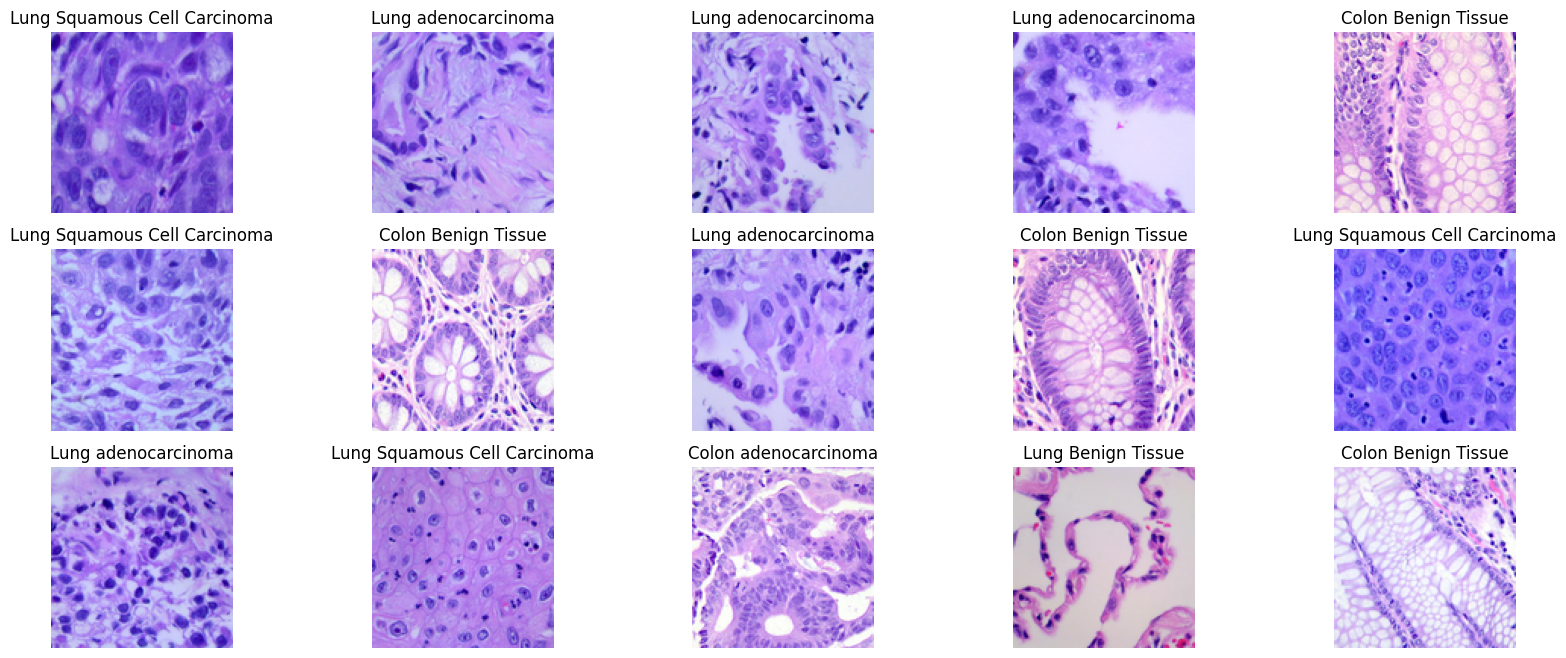

<Figure size 640x480 with 0 Axes>

In [4]:
from random import randint

fig, axes = plt.subplots (3, 5, figsize = (20, 8))

#taking 15 random images and plotting them in the subplot with their corresponding label
for i in range(3):
    for j in range(5):
        idx = randint(0, 25000)
        axes[i, j].imshow(data[idx])
        axes[i, j].set_title(labels[idx])
        axes[i, j].axis('off')

plt.show()

plt.tight_layout()

## Visualizing Class Distribution

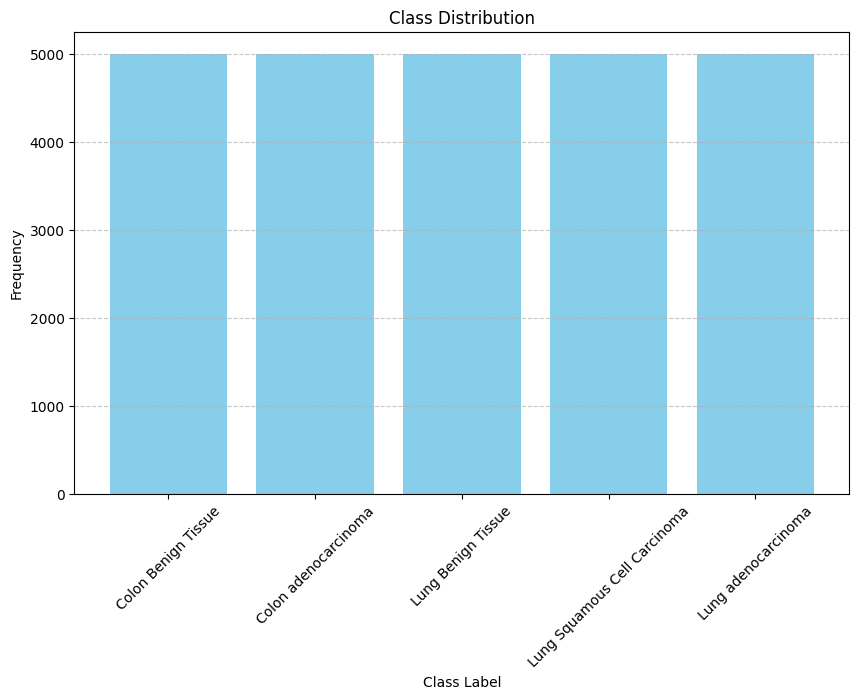

In [5]:
unique_classes, class_counts = np.unique(labels, return_counts=True)

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.xticks(unique_classes, rotation = 45)  # Ensure all class labels are shown on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##Train-Test-Val Split

In [6]:
from sklearn.model_selection import train_test_split
#we have to dn an intermediate split of the data in order to further split into the desired 60 / 20 / 20 ratio
X_train_val, X_test, y_train_val, y_test = train_test_split(data, one_hot_labels, test_size = 0.2, random_state=42, stratify=one_hot_labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# Evaluation Functions

In [7]:
## LOSS-ACC GRAPHS
def plot_training_history(history):
    # Define needed variables
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [8]:
#Confusion matrix:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(y_true, y_pred, classes):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, alpha=0.8)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.grid(False)  # Turn off strong grid lines
    plt.show()

In [26]:
# Classification Report:
from sklearn.metrics import classification_report
def print_classification_report(y_true, y_pred, class_names, title):
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(title)
    print(report)

In [18]:
#ROC curves

from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(model, X_test, y_test, title):
    n_classes = y_test.shape[1]

    y_score = model.predict(X_test)

    # Initialize variables to store fpr and tpr for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    # Calculate ROC curve for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) - AUC = {:.2f}'.format(i, roc_auc[i]))

    plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (AUC = {:.2f})'.format(roc_auc_micro), linestyle=':', linewidth=4)

    plt.plot(fpr_macro, tpr_macro, label='Macro-average ROC curve (AUC = {:.2f})'.format(roc_auc_macro), linestyle='--', linewidth=4)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Baseline Model

In [11]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from warnings import filters

In [12]:
# this defines the sequential baseline model consisting of 2 convolution layers, 2 max-pooling and two dense layers followed by the output layer
baseline_model = Sequential()
baseline_model.add(layers.Conv2D(128, (3, 3), padding = 'same', activation='relu', input_shape=X_train.shape[1:]))
baseline_model.add(layers.MaxPooling2D((2, 2)))
baseline_model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
baseline_model.add(layers.MaxPooling2D((2, 2)))

baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(128, activation='relu'))
baseline_model.add(layers.Dense(32, activation='relu'))
baseline_model.add(layers.Dense(5, activation='softmax'))

In [13]:
# compile the model using the adam optimizer, the categorical-cross entropy loss function and report the accuracy of the model
baseline_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# thre training history is stored in a variable, model is trained on X_train & y_train, validated on X_val & y_val
history = baseline_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
469/469 [==============================] - 23s 38ms/step - loss: 4.6721 - accuracy: 0.4891 - val_loss: 0.9196 - val_accuracy: 0.5618
Epoch 2/10
469/469 [==============================] - 15s 32ms/step - loss: 0.8011 - accuracy: 0.6171 - val_loss: 0.6492 - val_accuracy: 0.6752
Epoch 3/10
469/469 [==============================] - 16s 35ms/step - loss: 0.6485 - accuracy: 0.6983 - val_loss: 0.7126 - val_accuracy: 0.6540
Epoch 4/10
469/469 [==============================] - 15s 32ms/step - loss: 0.5919 - accuracy: 0.7183 - val_loss: 0.6935 - val_accuracy: 0.6668
Epoch 5/10
469/469 [==============================] - 15s 32ms/step - loss: 0.5496 - accuracy: 0.7361 - val_loss: 0.5918 - val_accuracy: 0.7294
Epoch 6/10
469/469 [==============================] - 15s 32ms/step - loss: 0.5237 - accuracy: 0.7571 - val_loss: 0.6422 - val_accuracy: 0.7384
Epoch 7/10
469/469 [==============================] - 15s 32ms/step - loss: 0.5022 - accuracy: 0.7676 - val_loss: 0.7045 - val_accuracy:

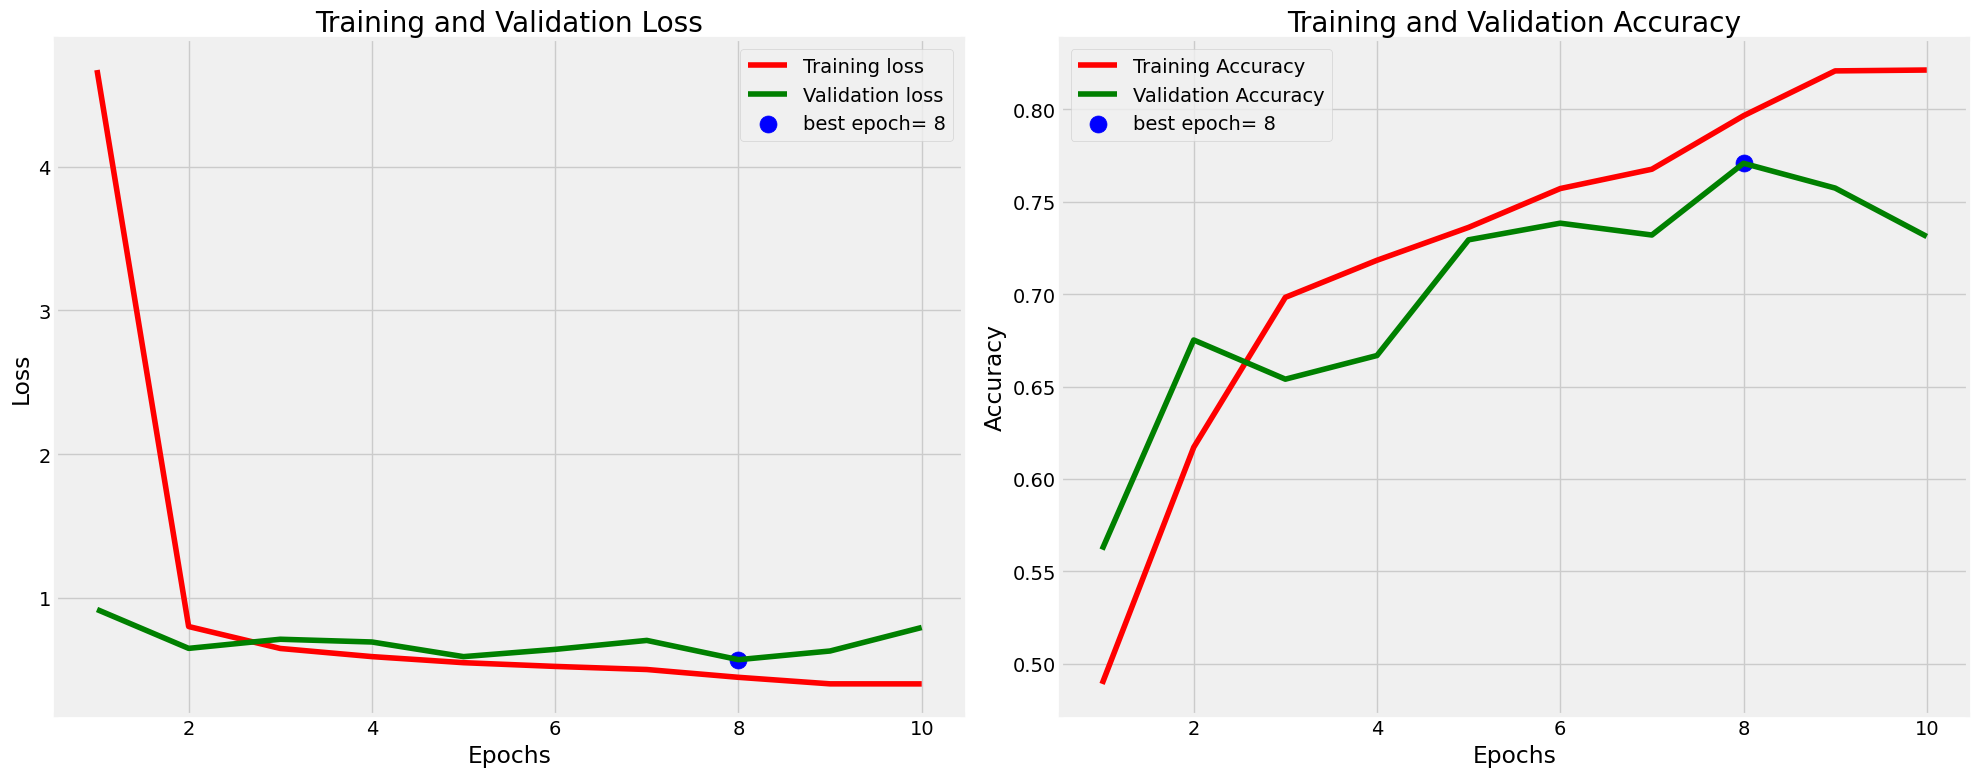

In [14]:
plot_training_history(history)

157/157 [==============================] - 1s 7ms/step


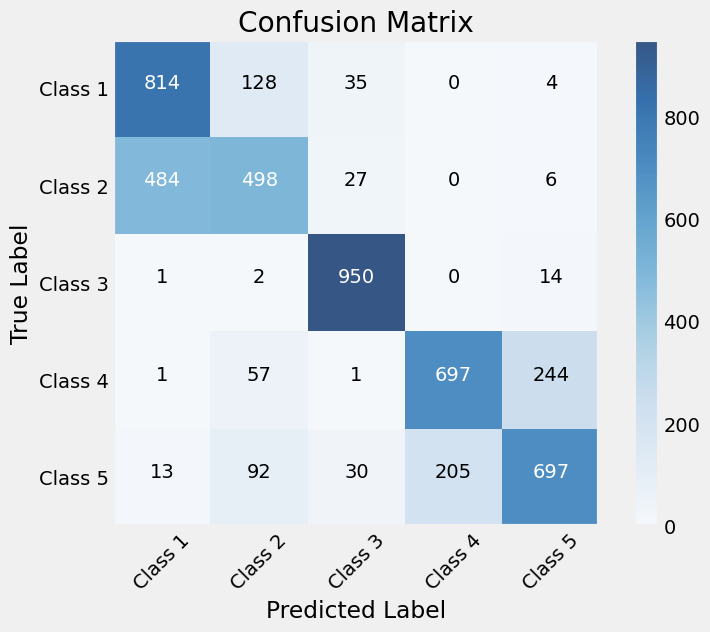

In [15]:
y_pred_prob_val = baseline_model.predict(X_val)
y_pred_val = y_pred_prob_val.argmax (axis = 1)
y_true = np.argmax(y_val, axis=1)
classes = ["Class 1", "Class 2", "Class 3", 'Class 4', 'Class 5']
plot_confusion_matrix(y_true, y_pred_val, classes)

157/157 [==============================] - 1s 7ms/step


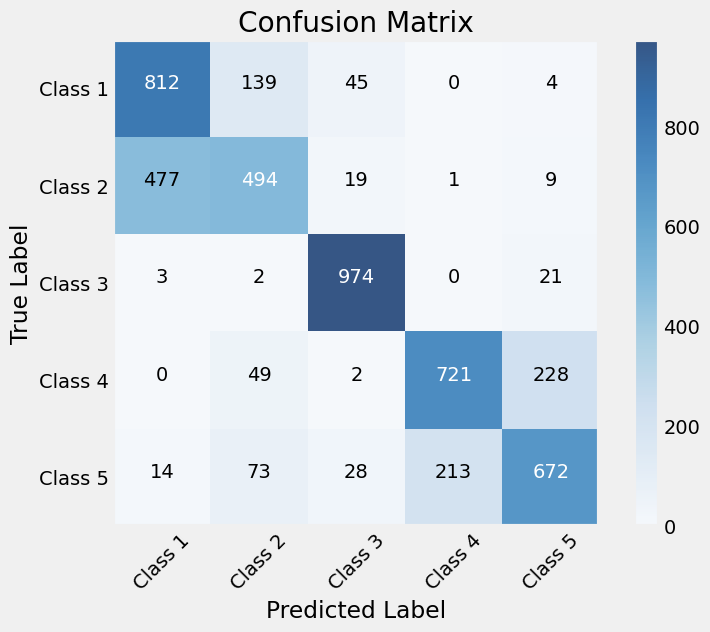

In [16]:
y_pred_prob_test = baseline_model.predict(X_test)
y_pred_test = y_pred_prob_test.argmax (axis = 1)
y_true_test = np.argmax(y_test, axis=1)
classes = ["Class 1", "Class 2", "Class 3", 'Class 4', 'Class 5']
plot_confusion_matrix(y_true_test, y_pred_test, classes)

157/157 [==============================] - 3s 17ms/step


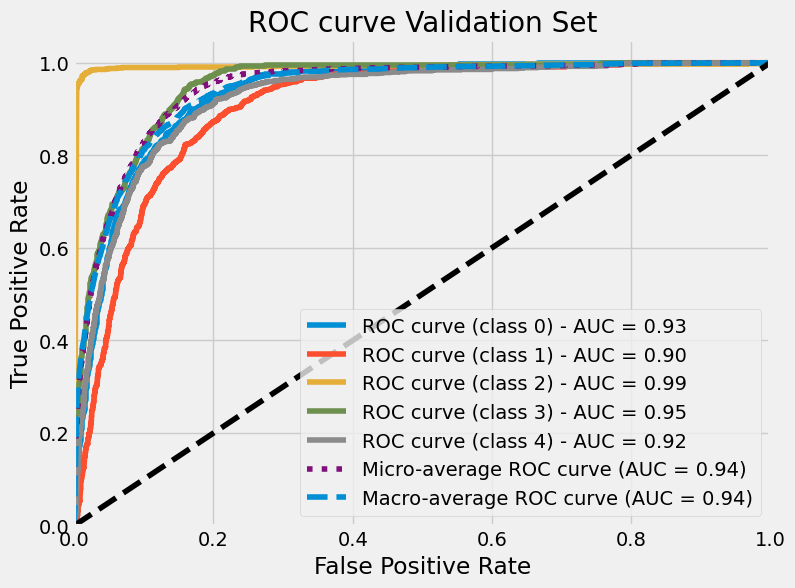

In [23]:
plot_multiclass_roc(baseline_model, X_val, y_val,'ROC curve Validation Set')

157/157 [==============================] - 1s 7ms/step


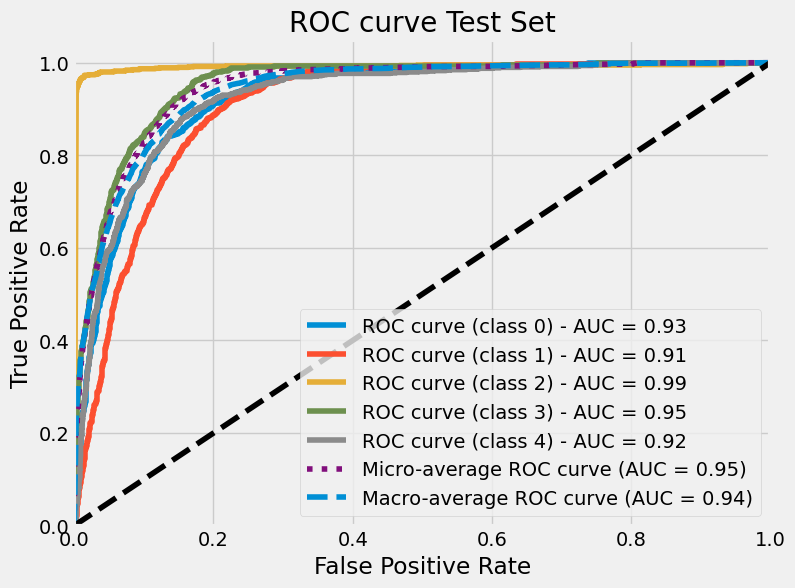

In [24]:
plot_multiclass_roc(baseline_model, X_test, y_test,'ROC curve Test Set')

In [28]:
print_classification_report(y_true, y_pred_val, classes, 'Performance measures on Validation set:')

Performance measures on Validation set:
              precision    recall  f1-score   support

     Class 1       0.62      0.83      0.71       981
     Class 2       0.64      0.49      0.56      1015
     Class 3       0.91      0.98      0.95       967
     Class 4       0.77      0.70      0.73      1000
     Class 5       0.72      0.67      0.70      1037

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



In [29]:
print_classification_report(y_true_test, y_pred_test, classes, 'Performance measures on Test set:')

Performance measures on Test set:
              precision    recall  f1-score   support

     Class 1       0.62      0.81      0.70      1000
     Class 2       0.65      0.49      0.56      1000
     Class 3       0.91      0.97      0.94      1000
     Class 4       0.77      0.72      0.75      1000
     Class 5       0.72      0.67      0.69      1000

    accuracy                           0.73      5000
   macro avg       0.74      0.73      0.73      5000
weighted avg       0.74      0.73      0.73      5000



# Enhanced Model

In [30]:
#this installs the KerasTuner which is the tool that allows us to search for the optimal hyperparameters
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [31]:
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import json

<ipython-input-31-158ed9c3ee7f>:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [1]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Choice('filter_size_1', [32, 64, 128, 256]),
                     kernel_size=(hp.Choice('kernel_size_lyr_1_1', [2, 3, 5]), hp.Choice('kernel_size_lyr_1_2', [2, 3, 5])),
                     padding='same', activation='relu', input_shape=X_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(hp.Choice('pool_size_lyr_1_1', [2, 3]), hp.Choice('pool_size_lyr_1_2', [2, 3]))))

    model.add(Conv2D(hp.Choice('filter_size_2', [64, 128, 256]),
                     kernel_size=(hp.Choice('kernel_size_lyr_2_1', [2, 3, 5]), hp.Choice('kernel_size_lyr_2_2', [2, 3, 5])),
                     padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(hp.Choice('pool_size_lyr_2_1', [2, 3]), hp.Choice('pool_size_lyr_2_2', [2, 3]))))

    model.add(Conv2D(hp.Choice('filter_size_3', [128, 256]),
                     kernel_size=(hp.Choice('kernel_size_lyr_3_1', [2, 3, 5]), hp.Choice('kernel_size_lyr_3_2', [2, 3, 5])),
                     padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(hp.Choice('pool_size_lyr_3_1', [2, 3]), hp.Choice('pool_size_lyr_3_2', [2, 3]))))

    model.add(Conv2D(hp.Choice('filter_size_4', [128, 256]),
                     kernel_size=(hp.Choice('kernel_size_lyr_4_1', [2, 3, 5]), hp.Choice('kernel_size_lyr_4_2', [2, 3, 5])),
                     padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(hp.Choice('pool_size_lyr_4_1', [2, 3]), hp.Choice('pool_size_lyr_4_2', [2, 3]))))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(hp.Choice('dropout_rate', [0.0, 0.1, 0.2, 0.5])))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(5, activation='softmax'))

    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'adamax', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# sets the search method as random search, the maximum number of combinations of hyperperamaters and the number of executions per trial
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=3,
    directory='keras_tuner_results',
    project_name='cnn_hyperparameter_tuning'
)

# Search for the best hyperparameters
tuner.search(x=X_train, y=y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model
best_model = tuner.hypermodel.build(best_hyperparameters)

Trial 20 Complete [00h 18m 49s]
val_accuracy: 0.9659333427747091

Best val_accuracy So Far: 0.9735333323478699
Total elapsed time: 04h 31m 09s


In [32]:
save_directory = '/content/drive/My Drive/dl/'

Only run the cell below if the build_model() function has been run and the tning has been done otherwise there will an error will be thrown, the cell below is saving the best hyperamaters to an external directory in order to save them for later use in the case of a session restart

In [ ]:
best_hyperparameters_dict = best_hyperparameters.get_config()
# Save the dictionary to a JSON file
with open(save_directory + 'best_hyperparameters.json', 'w') as file:
    json.dump(best_hyperparameters_dict, file)

In [34]:
json_file_path = save_directory + 'best_hyperparameters.json'
with open(json_file_path, 'r') as file:
    best_hyperparameters_dict = json.load(file)

In [35]:
best_hyperparameters = HyperParameters.from_config(best_hyperparameters_dict)
print(best_hyperparameters.values)

{'filter_size_1': 128, 'kernel_size_lyr_1_1': 2, 'kernel_size_lyr_1_2': 5, 'pool_size_lyr_1_1': 2, 'pool_size_lyr_1_2': 3, 'filter_size_2': 128, 'kernel_size_lyr_2_1': 3, 'kernel_size_lyr_2_2': 5, 'pool_size_lyr_2_1': 2, 'pool_size_lyr_2_2': 2, 'filter_size_3': 256, 'kernel_size_lyr_3_1': 2, 'kernel_size_lyr_3_2': 5, 'pool_size_lyr_3_1': 2, 'pool_size_lyr_3_2': 2, 'filter_size_4': 256, 'kernel_size_lyr_4_1': 2, 'kernel_size_lyr_4_2': 2, 'pool_size_lyr_4_1': 3, 'pool_size_lyr_4_2': 3, 'dropout_rate': 0.1, 'optimizer': 'adamax'}


In [36]:
best = Sequential()
best.add(layers.Conv2D(128, (2, 5), padding = 'same', activation='relu', input_shape=X_train.shape[1:]))
best.add(layers.MaxPooling2D((2, 3)))
best.add(layers.Conv2D(128, (3, 5), activation='relu', padding = 'same'))
best.add(layers.MaxPooling2D((2, 2)))

best.add(layers.Conv2D(256, (2, 5), padding = 'same', activation='relu'))
best.add(layers.MaxPooling2D((2, 2)))
best.add(layers.Conv2D(256, (2, 2), activation='relu', padding = 'same'))
best.add(layers.MaxPooling2D((3, 3)))

best.add(Flatten())
best.add(Dense(256, activation='relu'))
best.add(Dropout(0.1))
best.add(Dense(64, activation='relu'))
best.add(Dense(5, activation='softmax'))

In [37]:
best.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
best_history = best.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
469/469 [==============================] - 32s 56ms/step - loss: 1.1754 - accuracy: 0.7077 - val_loss: 0.3670 - val_accuracy: 0.8478
Epoch 2/10
469/469 [==============================] - 24s 52ms/step - loss: 0.3602 - accuracy: 0.8486 - val_loss: 0.2632 - val_accuracy: 0.8952
Epoch 3/10
469/469 [==============================] - 24s 50ms/step - loss: 0.2474 - accuracy: 0.9010 - val_loss: 0.1816 - val_accuracy: 0.9364
Epoch 4/10
469/469 [==============================] - 23s 50ms/step - loss: 0.1993 - accuracy: 0.9226 - val_loss: 0.1681 - val_accuracy: 0.9400
Epoch 5/10
469/469 [==============================] - 24s 51ms/step - loss: 0.1576 - accuracy: 0.9373 - val_loss: 0.1694 - val_accuracy: 0.9286
Epoch 6/10
469/469 [==============================] - 24s 50ms/step - loss: 0.1290 - accuracy: 0.9483 - val_loss: 0.1174 - val_accuracy: 0.9546
Epoch 7/10
469/469 [==============================] - 24s 52ms/step - loss: 0.1116 - accuracy: 0.9565 - val_loss: 0.1217 - val_accuracy:

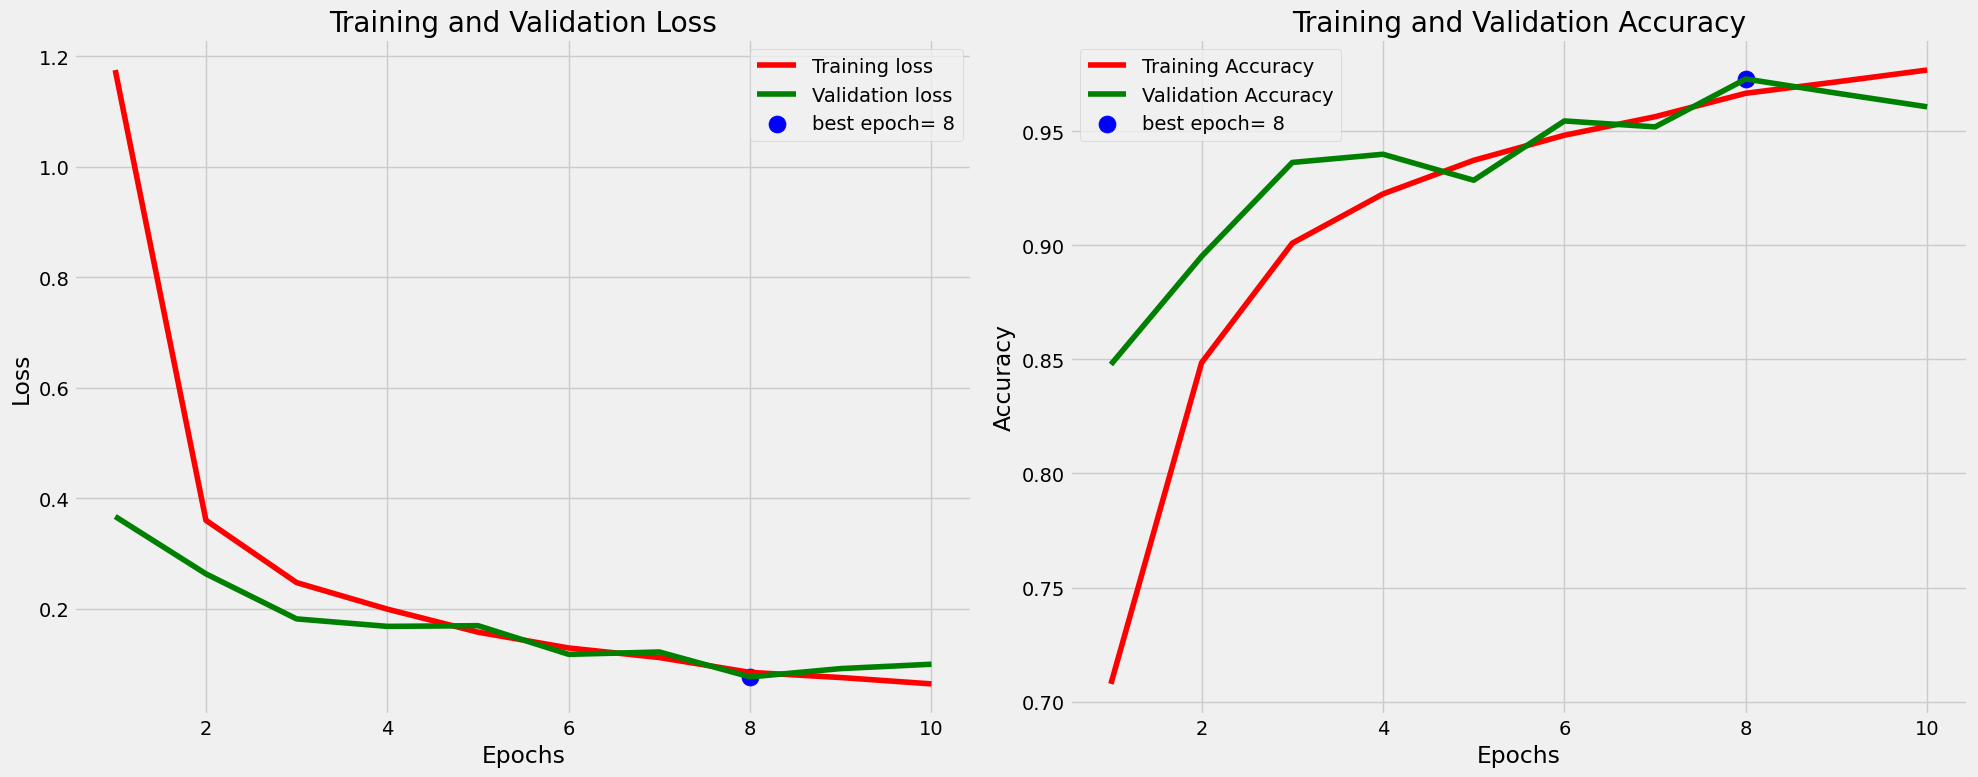

In [38]:
plot_training_history(best_history)

157/157 [==============================] - 2s 12ms/step


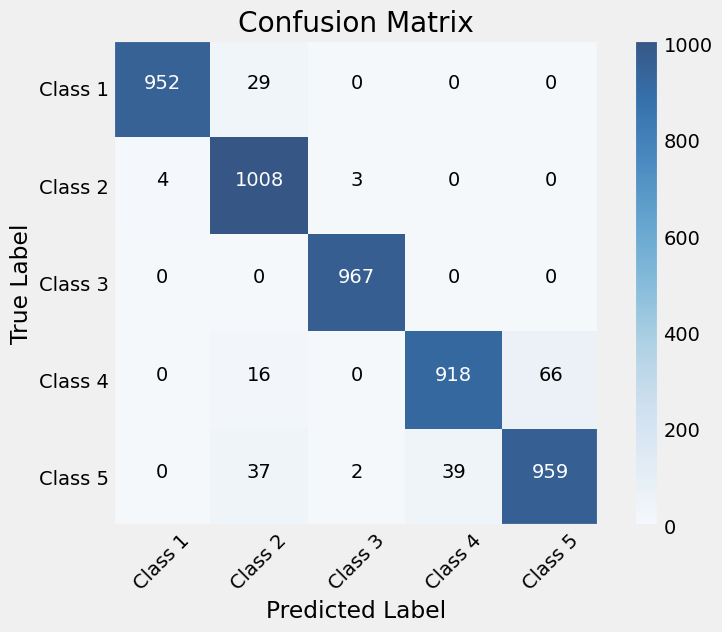

In [39]:
y_pred_prob_val_best = best.predict(X_val)
y_pred_val_best = y_pred_prob_val_best.argmax (axis = 1)
y_true_val_best = np.argmax(y_val, axis=1)
classes = ["Class 1", "Class 2", "Class 3", 'Class 4', 'Class 5']
plot_confusion_matrix(y_true_val_best, y_pred_val_best, classes)

157/157 [==============================] - 2s 12ms/step


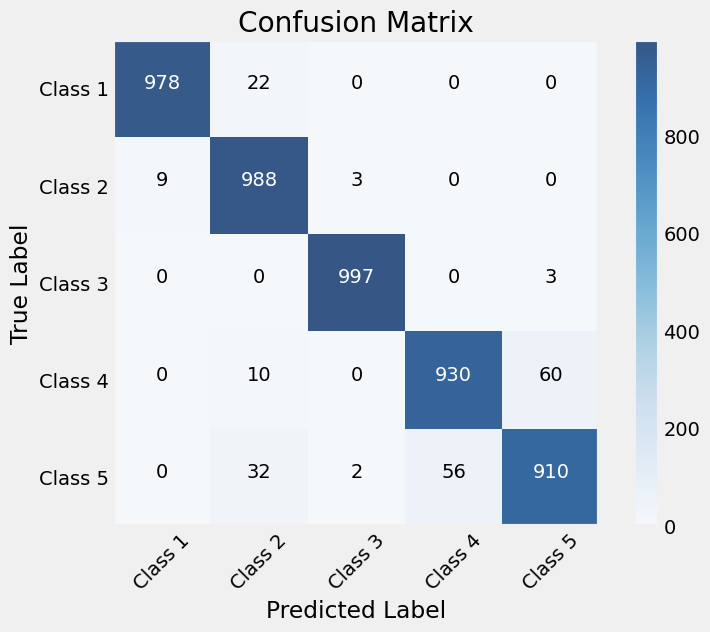

In [40]:
y_pred_prob_test_best = best.predict(X_test)
y_pred_test_best = y_pred_prob_test_best.argmax (axis = 1)
y_true_test_best = np.argmax(y_test, axis=1)
classes = ["Class 1", "Class 2", "Class 3", 'Class 4', 'Class 5']
plot_confusion_matrix(y_true_test_best, y_pred_test_best, classes)

157/157 [==============================] - 3s 19ms/step


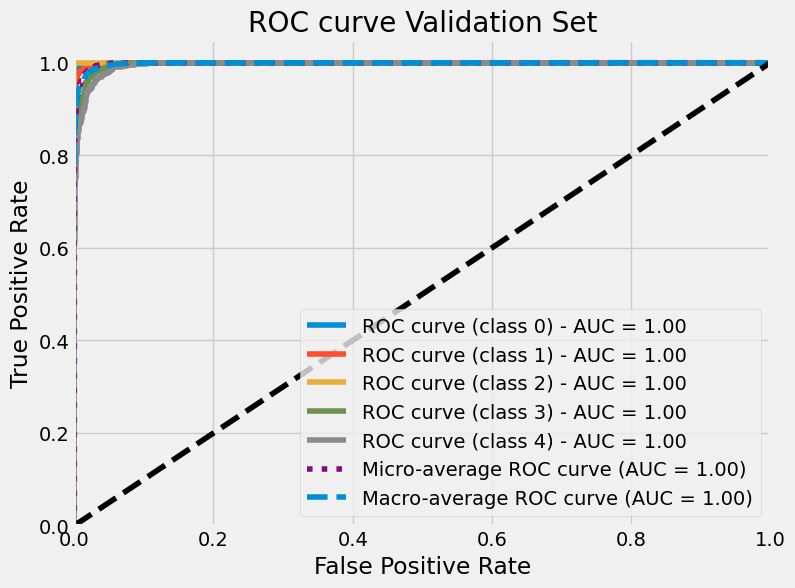

In [41]:
plot_multiclass_roc(best, X_val, y_val,'ROC curve Validation Set')

157/157 [==============================] - 2s 13ms/step


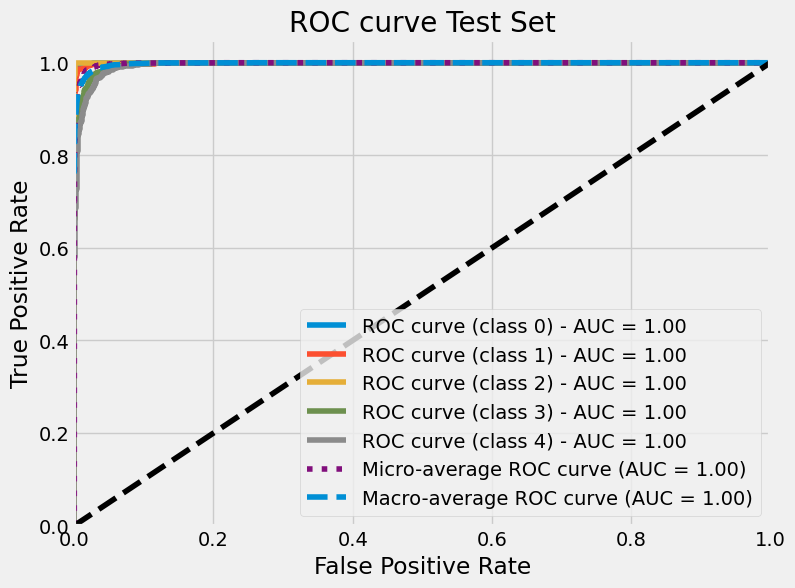

In [42]:
plot_multiclass_roc(best, X_test, y_test,'ROC curve Test Set')

In [43]:
print_classification_report(y_true, y_pred_val_best, classes, 'Performance measures on Validation set:')

Performance measures on Validation set:
              precision    recall  f1-score   support

     Class 1       1.00      0.97      0.98       981
     Class 2       0.92      0.99      0.96      1015
     Class 3       0.99      1.00      1.00       967
     Class 4       0.96      0.92      0.94      1000
     Class 5       0.94      0.92      0.93      1037

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



In [44]:
print_classification_report(y_true_test, y_pred_test_best, classes, 'Performance measures on Test set:')

Performance measures on Test set:
              precision    recall  f1-score   support

     Class 1       0.99      0.98      0.98      1000
     Class 2       0.94      0.99      0.96      1000
     Class 3       1.00      1.00      1.00      1000
     Class 4       0.94      0.93      0.94      1000
     Class 5       0.94      0.91      0.92      1000

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



# Transfer Learning Model


In [45]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [46]:
resnet = ResNet50(input_shape= X_train.shape[1:], weights='imagenet', include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [47]:
#freezing all layers in the model
for layer in resnet.layers:
    layer.trainable = False

In [48]:
from keras.models import Model
# adding two dense layers and the. output layer to the network
flat = Flatten()(resnet.layers[-1].output)
dense1 = Dense(256, activation = 'relu')(flat)
dense2 = Dense(128, activation = 'relu')(dense1)
pred = Dense(5, activation = 'softmax')(dense2)

resnet = Model(inputs=resnet.inputs, outputs=pred)
resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 126, 126, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 60, 60, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 60, 60, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [49]:
resnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


transfer_history = resnet.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, verbose=1)

Epoch 1/3
469/469 [==============================] - 30s 52ms/step - loss: 0.2478 - accuracy: 0.9377 - val_loss: 0.0761 - val_accuracy: 0.9714
Epoch 2/3
469/469 [==============================] - 22s 46ms/step - loss: 0.0711 - accuracy: 0.9751 - val_loss: 0.0788 - val_accuracy: 0.9726
Epoch 3/3
469/469 [==============================] - 21s 45ms/step - loss: 0.0412 - accuracy: 0.9857 - val_loss: 0.0603 - val_accuracy: 0.9822


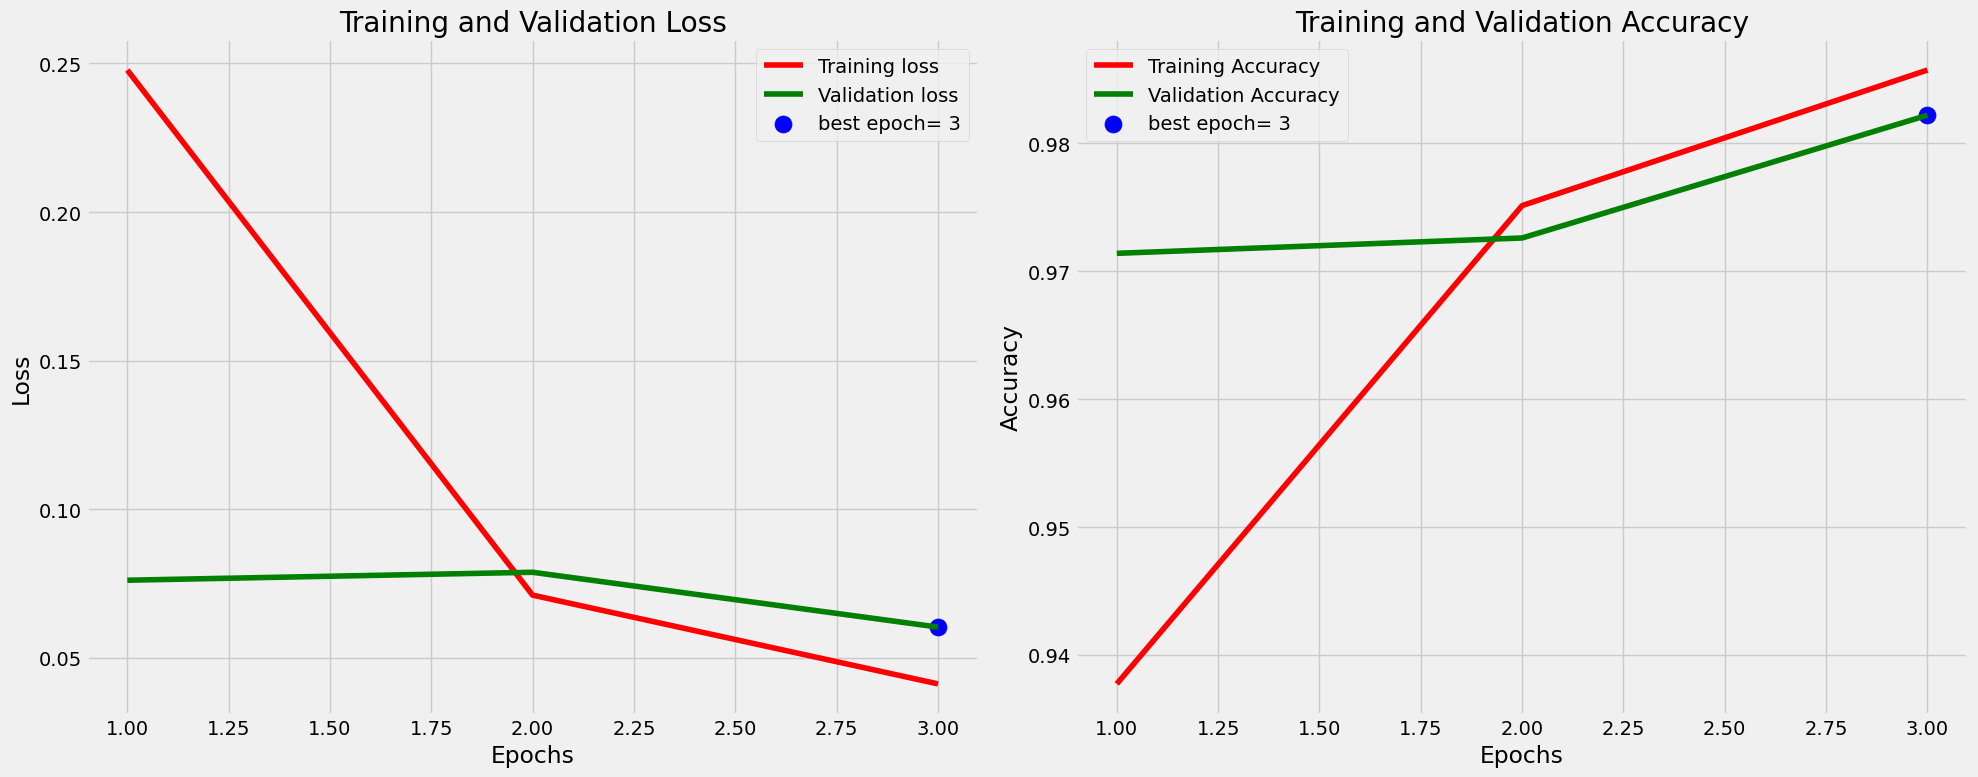

In [50]:
plot_training_history(transfer_history)

157/157 [==============================] - 6s 31ms/step


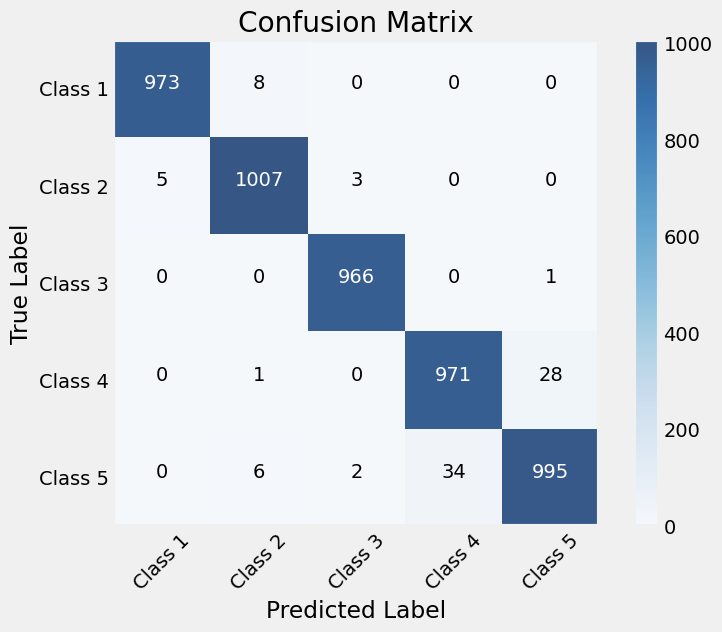

In [51]:
y_pred_prob_val_transfer = resnet.predict(X_val)
y_pred_val_transfer = y_pred_prob_val_transfer.argmax (axis = 1)
y_true_val_transfer = np.argmax(y_val, axis=1)
classes = ["Class 1", "Class 2", "Class 3", 'Class 4', 'Class 5']
plot_confusion_matrix(y_true_val_transfer, y_pred_val_transfer, classes)

157/157 [==============================] - 5s 30ms/step


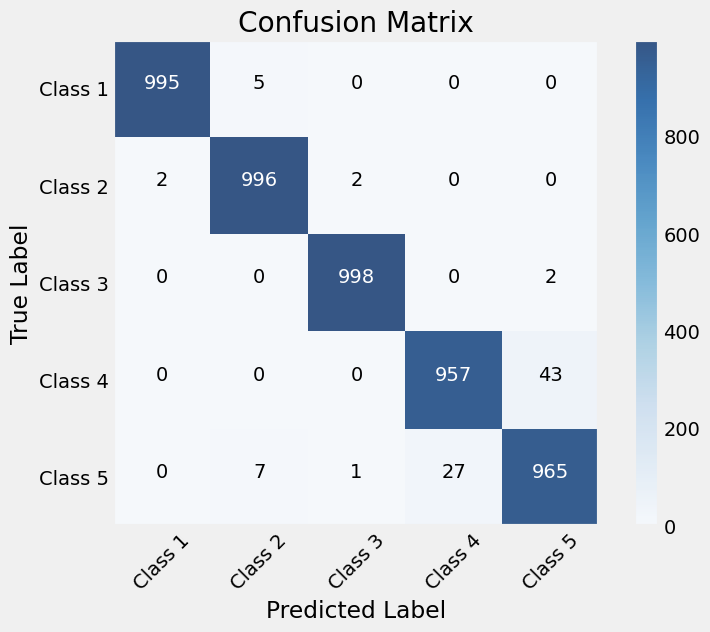

In [52]:
y_pred_prob_test_transfer = resnet.predict(X_test)
y_pred_test_transfer = y_pred_prob_test_transfer.argmax(axis = 1)
y_true_test_transfer = np.argmax(y_test, axis=1)
classes = ["Class 1", "Class 2", "Class 3", 'Class 4', 'Class 5']
plot_confusion_matrix(y_true_test_transfer, y_pred_test_transfer, classes)

157/157 [==============================] - 6s 37ms/step


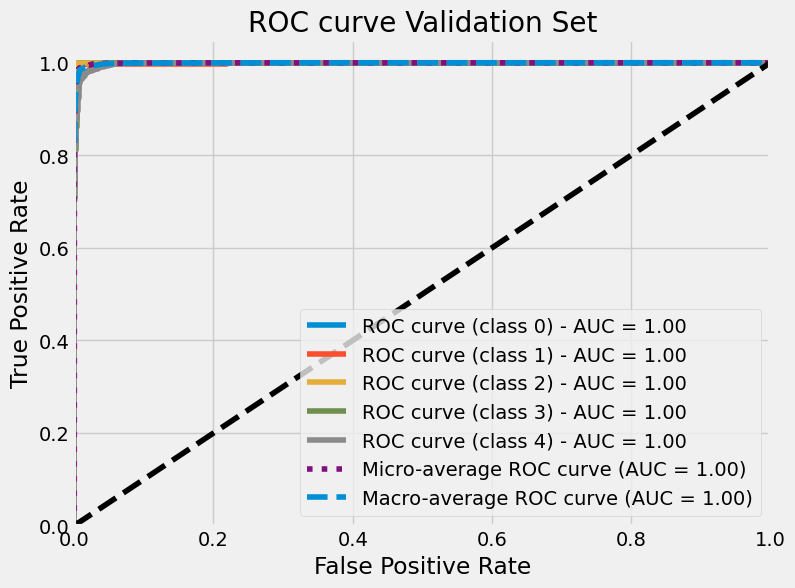

In [53]:
plot_multiclass_roc(resnet, X_val, y_val,'ROC curve Validation Set')

157/157 [==============================] - 5s 34ms/step


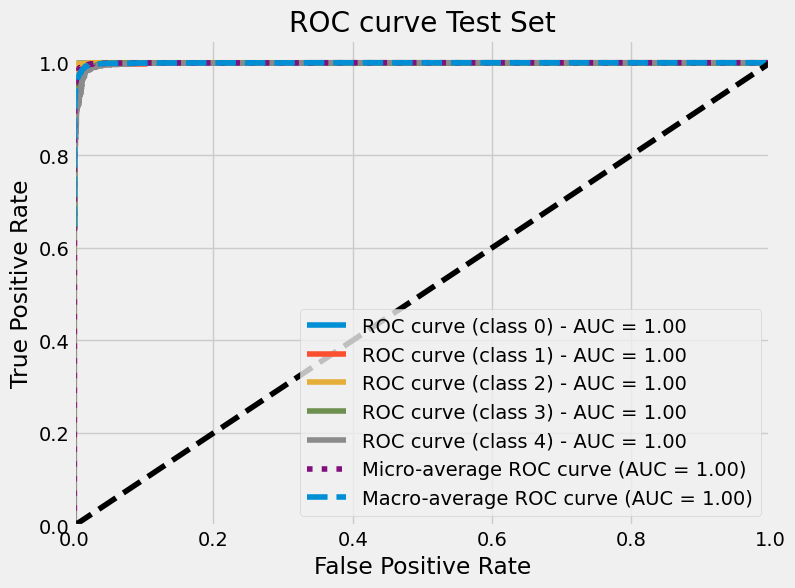

In [54]:
plot_multiclass_roc(resnet, X_test, y_test,'ROC curve Test Set')

In [56]:
print_classification_report(y_true_val_transfer, y_pred_val_transfer, classes, 'Performance measures on Validation set:')

Performance measures on Validation set:
              precision    recall  f1-score   support

     Class 1       0.99      0.99      0.99       981
     Class 2       0.99      0.99      0.99      1015
     Class 3       0.99      1.00      1.00       967
     Class 4       0.97      0.97      0.97      1000
     Class 5       0.97      0.96      0.97      1037

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000



In [57]:
print_classification_report(y_true_test_transfer, y_pred_test_transfer, classes, 'Performance measures on Test set:')

Performance measures on Test set:
              precision    recall  f1-score   support

     Class 1       1.00      0.99      1.00      1000
     Class 2       0.99      1.00      0.99      1000
     Class 3       1.00      1.00      1.00      1000
     Class 4       0.97      0.96      0.96      1000
     Class 5       0.96      0.96      0.96      1000

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

